In [1]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import ScalarFormatter
sns.set_theme(style="whitegrid", palette="deep")
palette = sns.color_palette("deep")
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
sns.set_theme(style="whitegrid", palette="deep")
np.random.seed(44)

In [7]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=True) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_lfu(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lfu = [tg.sim_lfu(int(_c), trace, raw=True) for _c in c]
    return c, hr_lfu

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

In [5]:
def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, length, mu_ratio=10.0):
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()

    alpha0 = 0.5
    alpha = np.array([0.5, 0.5], dtype=float)

    mu2 = (1.0 / mu_ratio + 1.0) / 2.0
    mu1 = mu_ratio * mu2
    T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)

    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a, b = P[0, 1], P[1, 0]
    beta = np.array([0.5, 0.5], dtype=float) if a + b == 0 else np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    t /= arate

    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)

    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        heapq.heappush(heap, (ctime + np.random.exponential(1.0 / rate), item))
    return trace

In [3]:
# lmb, irm2 = gen_from_zipf(120, 10000000, 0.8)
# he2 = gen_ph(120, 0.8, 10000000)
# ph2 = gen_ph_2class(120, 0.8, 10000000, mu_ratio=10.0)
irm2 = np.loadtxt('zipf_120_08_trace.txt', dtype=np.int32)
he2 = np.loadtxt('he_120_08_trace.txt', dtype=np.int32)
ph2 = np.loadtxt('ph_120_08_trace.txt', dtype=np.int32)

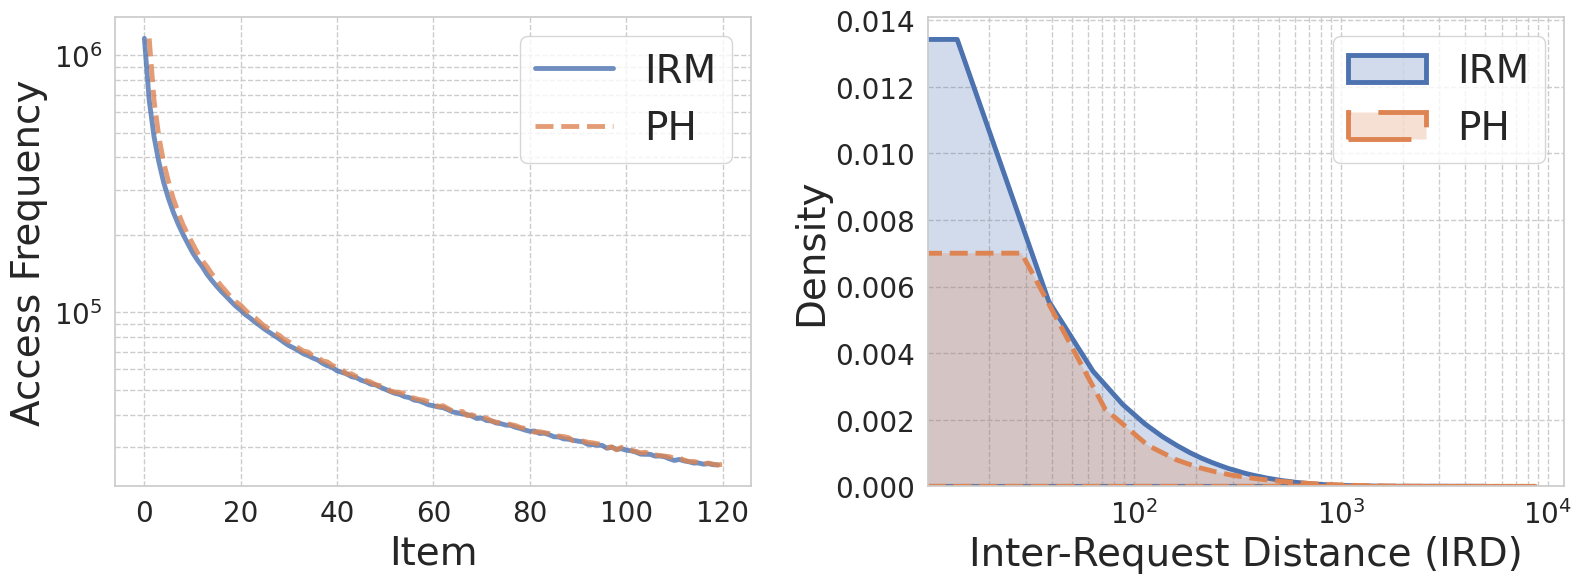

In [46]:
# u1, c1 = np.unique(irm2, return_counts=True)
# u2, c2 = np.unique(ph2, return_counts=True)

# iads1 = tg.iad(irm2)
# iads1 = iads1[iads1 > 0]
# iads2 = tg.iad(ph2)
# iads2 = iads2[iads2 > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Access frequency
ax1.semilogy(u1, c1, label='IRM', lw=3.5, color=palette[0], alpha=0.8)
ax1.semilogy(u2, c2, label='PH', lw=3.5, color=palette[1], alpha=0.8, linestyle='--')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('Item', fontsize=28)
ax1.set_ylabel('Access Frequency', fontsize=28)
ax1.legend(fontsize=28)
ax1.grid(True, which="both", ls="--")

# IRD KDE
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True, ax=ax2, color=palette[0], common_norm=False, linewidth=3.5)
sns.kdeplot(iads2, bw_adjust=0.5, label='PH', fill=True, ax=ax2, color=palette[1], common_norm=False, linewidth=3.5, linestyle='--')
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.get_major_formatter().set_scientific(True)
ax2.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xscale('log')
ax2.set_xlabel('Inter-Request Distance (IRD)', fontsize=28)
ax2.set_ylabel('Density', fontsize=28)
ax2.legend(fontsize=28)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.savefig('freqs_irds2.pdf', bbox_inches='tight', format='pdf')
plt.show()



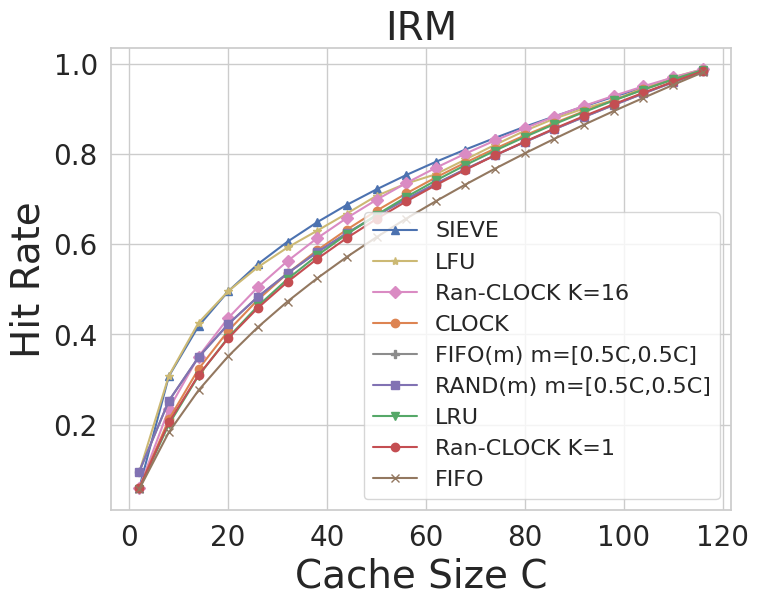

IRM Average Hit Rates:
SIEVE: 0.7084600400000001
LFU: 0.7016686999999998
Ran-CLOCK K=16: 0.687391185
CLOCK: 0.6694223849999998
FIFO(m) m=[0.5C,0.5C]: 0.66832016
RAND(m) m=[0.5C,0.5C]: 0.6682769949999999
LRU: 0.662796135
Ran-CLOCK K=1: 0.656600905
FIFO: 0.6291371400000001


In [13]:
# c1, hr_ran_clock1 = sim_ran_clock(irm2, cnt=1)
# c16, hr_ran_clock16 = sim_ran_clock(irm2, cnt=16)
# cl, hr_fifo_m = sim_fifo_m(irm2)
# cr, hr_rand_m = sim_rand_m(irm2)
# cc, hr_clock = sim_clock(irm2)
# cs, hr_sieve = sim_sieve(irm2)
# cl, hr_lru = sim_lru(irm2)
# cf, hr_fifo = sim_fifo(irm2)
# cfq, hr_lfu = sim_lfu(irm2)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(True)
# ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(True)
# ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cfq, hr_lfu, color=palette[8], marker='*', label='LFU')
plt.plot(c16, hr_ran_clock16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cr, hr_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(c1, hr_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=16)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_irm.pdf', bbox_inches='tight', format='pdf')
plt.show()

avgs = [('LFU', np.mean(np.array(hr_lfu))),
        ('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK K=1', np.mean(np.array(hr_ran_clock1))),
        ('Ran-CLOCK K=16', np.mean(np.array(hr_ran_clock16))),
        ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_rand_m))),
        ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_fifo_m))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

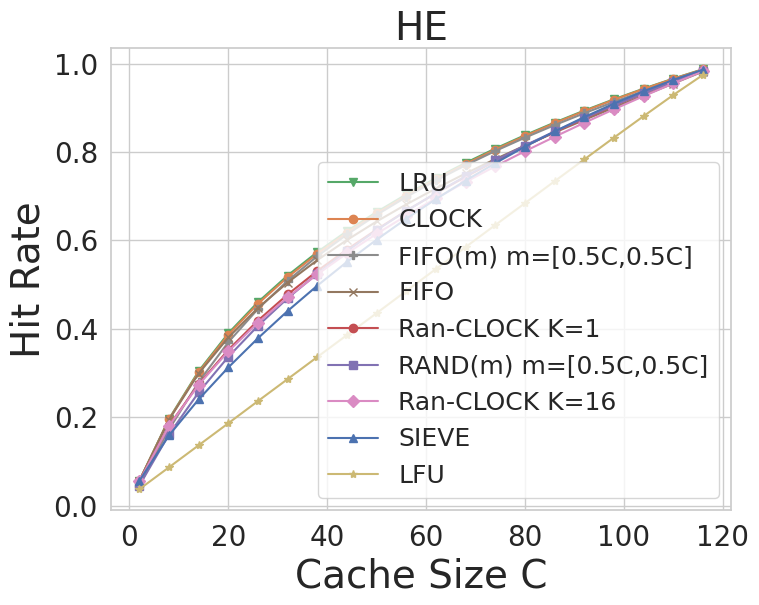

HE Average Hit Rates:
LRU: 0.6613075150000001
CLOCK: 0.65915747
FIFO(m) m=[0.5C,0.5C]: 0.65189007
FIFO: 0.64545666
Ran-CLOCK K=1: 0.635129455
RAND(m) m=[0.5C,0.5C]: 0.630816915
Ran-CLOCK K=16: 0.628171775
SIEVE: 0.621065105
LFU: 0.5091558


In [7]:
che1, hr_he_ran_clock1 = sim_ran_clock(he2, cnt=1)
che16, hr_he_ran_clock16 = sim_ran_clock(he2, cnt=16)
cl_he, hr_he_fifo_m = sim_fifo_m(he2)
cr_he, hr_he_rand_m = sim_rand_m(he2)
cc_he, hr_he_clock = sim_clock(he2)
cs_he, hr_he_sieve = sim_sieve(he2)
cl_he, hr_he_lru = sim_lru(he2)
cf_he, hr_he_fifo = sim_fifo(he2)
cfq_he, hr_he_lfu = sim_lfu(he2)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cl_he, hr_he_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cc_he, hr_he_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl_he, hr_he_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cf_he, hr_he_fifo, color=palette[5], marker='x', label='FIFO')
plt.plot(che1, hr_he_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cr_he, hr_he_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(che16, hr_he_ran_clock16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(cs_he, hr_he_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cfq_he, hr_he_lfu, color=palette[8], marker='*', label='LFU')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_he.pdf', bbox_inches='tight', format='pdf')
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_he_sieve))),
         ('CLOCK', np.mean(np.array(hr_he_clock))),
         ('LRU', np.mean(np.array(hr_he_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_he_ran_clock1))),
         ('Ran-CLOCK K=16', np.mean(np.array(hr_he_ran_clock16))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_he_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_he_fifo_m))),
         ('FIFO', np.mean(np.array(hr_he_fifo))),
         ('LFU', np.mean(np.array(hr_he_lfu)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

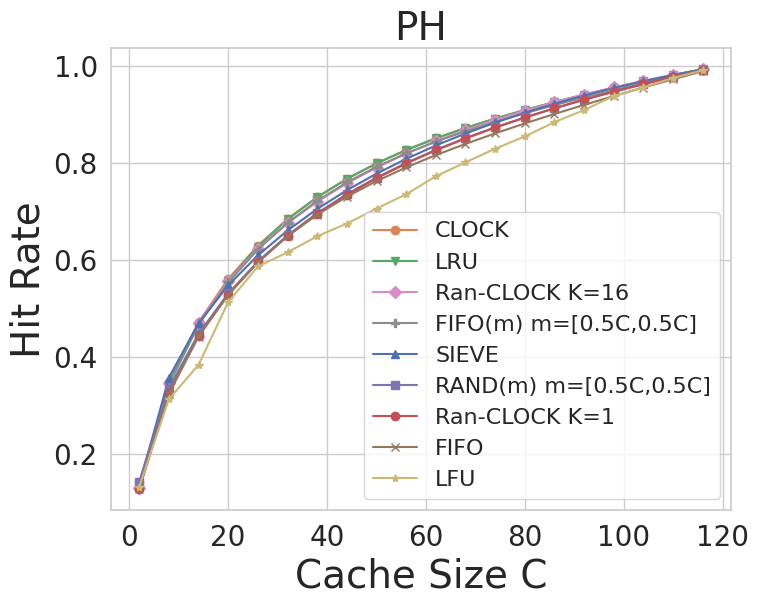

PH Average Hit Rates:
CLOCK: 0.7619064749999999
LRU: 0.76100982
Ran-CLOCK K=16: 0.7583137200000001
FIFO(m) m=[0.5C,0.5C]: 0.756843135
SIEVE: 0.7528033849999999
RAND(m) m=[0.5C,0.5C]: 0.743623
Ran-CLOCK K=1: 0.7416053499999999
FIFO: 0.7359527
LFU: 0.7111432950000001


In [11]:
# cph1, hr_ph_ran_clock1 = sim_ran_clock(ph2, cnt=1)
# cph16, hr_ph_ran_clock16 = sim_ran_clock(ph2, cnt=16)
# cl_ph, hr_ph_fifo_m = sim_fifo_m(ph2)
# cr_ph, hr_ph_rand_m = sim_rand_m(ph2)
# cc_ph, hr_ph_clock = sim_clock(ph2)
# cs_ph, hr_ph_sieve = sim_sieve(ph2)
# cl_ph, hr_ph_lru = sim_lru(ph2)
# cf_ph, hr_ph_fifo = sim_fifo(ph2)
# cfq_ph, hr_ph_lfu = sim_lfu(ph2)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cc_ph, hr_ph_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl_ph, hr_ph_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cph16, hr_ph_ran_clock16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(cl_ph, hr_ph_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cs_ph, hr_ph_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cr_ph, hr_ph_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cph1, hr_ph_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf_ph, hr_ph_fifo, color=palette[5], marker='x', label='FIFO')
plt.plot(cfq_ph, hr_ph_lfu, color=palette[8], marker='*', label='LFU')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=16)
plt.title('PH', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_ph.pdf', bbox_inches='tight', format='pdf')
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_ph_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1))),
         ('Ran-CLOCK K=16', np.mean(np.array(hr_ph_ran_clock16))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo))),
         ('LFU', np.mean(np.array(hr_ph_lfu)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("PH Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

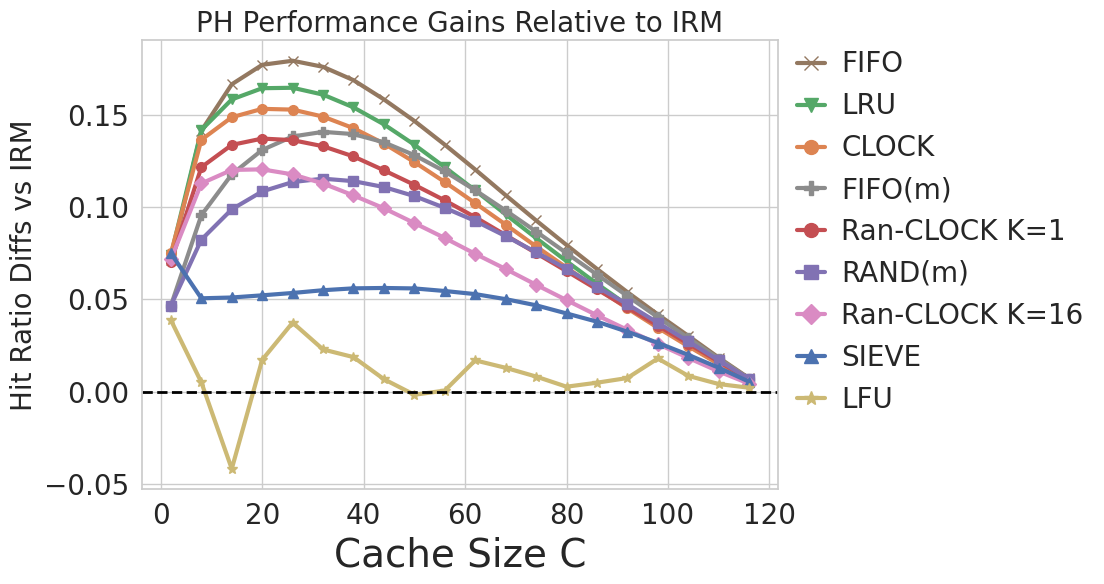

In [9]:
policies = ["FIFO", "LRU", "CLOCK", "FIFO(m)", "Ran-CLOCK K=1", "RAND(m)", "Ran-CLOCK K=16", "SIEVE", "LFU"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_fifo_m, hr_ran_clock1, hr_rand_m, hr_ran_clock16, hr_sieve, hr_lfu]
# he_hr  = [hr_he_fifo, hr_he_lru, hr_he_clock, hr_he_fifo_m, hr_he_ran_clock1, hr_he_rand_m, hr_he_ran_clock16, hr_he_sieve]
ph_hr  = [hr_ph_fifo, hr_ph_lru, hr_ph_clock, hr_ph_fifo_m, hr_ph_ran_clock1, hr_ph_rand_m, hr_ph_ran_clock16, hr_ph_sieve, hr_ph_lfu]
colors = [palette[5], palette[2], palette[1], palette[7], palette[3], palette[4], palette[6], palette[0], palette[8]]
markers = ['x', 'v', 'o', 'P', 'o', 's', 'D', '^', '*']
# linestyles = {'HE - IRM': '-', 'PH - IRM': ':'}
linestyles = {'PH - IRM': '-'}

c = cph1
rows = []
# for name, irm, he, ph in zip(policies, irm_hr, he_hr, ph_hr):
for name, irm, ph in zip(policies, irm_hr, ph_hr):
    irm = np.array(irm)
    # he  = np.array(he)
    ph  = np.array(ph)
    # deltas = [("HE - IRM", he - irm), ("PH - IRM", ph - irm)]
    deltas = [("PH - IRM", ph - irm)]
    for workload, delta in deltas:
        for C, d in zip(c, delta):
            rows.append({"C": C, "policy": name, "delta_hr": d, "workload": workload})

df_delta = pd.DataFrame(rows)
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', labelsize=20)
policy_handles, policy_labels = [], []
for name, color, marker in zip(policies, colors, markers):
    sub = df_delta[df_delta["policy"] == name]
    for workload, linestyle in linestyles.items():
        data = sub[sub["workload"] == workload]
        ax.plot(data["C"], data["delta_hr"], marker=marker, label=None, color=color, linestyle=linestyle, lw=3, markersize=7)
    policy_handles.append(Line2D([], [], color=color, marker=marker, linestyle="-", linewidth=3, markersize=10))
    policy_labels.append(name)

style_handles = [
    Line2D([], [], color='black', linestyle='-', linewidth=3),
    # Line2D([], [], color='black', linestyle='--', linewidth=3),
]
# style_labels = ['HE - IRM', 'PH - IRM']

fig.legend(policy_handles, policy_labels, loc='center left', bbox_to_anchor=(0.78, 0.60), ncol=1,
          fontsize=20, frameon=False, handlelength=1.0, handletextpad=0.6, columnspacing=0.8)
# fig.legend(style_handles, style_labels, loc='upper left', bbox_to_anchor=(0.78, 0.88), ncol=1,
        #   fontsize=20, frameon=False, handlelength=1.2, handletextpad=0.5, columnspacing=1.0)
ax.axhline(0, color='black', linewidth=2, linestyle='--')
ax.set_xlabel("Cache Size C", fontsize=28)
ax.set_ylabel("Hit Ratio Diffs vs IRM", fontsize=20)
ax.set_title("PH Performance Gains Relative to IRM", fontsize=20)
ax.grid(True)
fig.tight_layout(rect=[0, 0, 0.82, 1])
fig.savefig('mrcs_delta.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [10]:
avgs3 = [('SIEVE', np.mean(np.array(hr_ph_sieve) - np.array(hr_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock) - np.array(hr_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru) - np.array(hr_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1) - np.array(hr_ran_clock1))),
         ('Ran-CLOCK K=16', np.mean(np.array(hr_ph_ran_clock16) - np.array(hr_ran_clock16))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m) - np.array(hr_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m) - np.array(hr_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo) - np.array(hr_fifo))),
         ('LFU', np.mean(np.array(hr_ph_lfu) - np.array(hr_lfu)))]
avgs3.sort(key=lambda x: x[1], reverse=True)
print("Performance gains:")
for name, avg in avgs3:
    print(f"{name}: {avg}")

Performance gains:
FIFO: 0.10681555999999999
LRU: 0.09821368499999998
CLOCK: 0.09248408999999999
FIFO(m) m=[0.5C,0.5C]: 0.08852297500000002
Ran-CLOCK K=1: 0.08500444500000001
RAND(m) m=[0.5C,0.5C]: 0.075346005
Ran-CLOCK K=16: 0.07092253500000001
SIEVE: 0.04434334499999999
LFU: 0.009474595000000002


In [50]:
# verify simulation for fifo(m) matches paper
trace = gen_from_zipf(300, 20000000, 0.8)[1]
hr1 = tg.sim_fifo_m([2, 98], trace)
hr2 = tg.sim_fifo_m([30, 70], trace)
hr3 = tg.sim_fifo_m([98, 2], trace)
print(1-hr1, 1-hr2, 1-hr3)
trace2 = gen_from_zipf(3000, 20000000, 0.8)[1]
hr11 = tg.sim_fifo_m([20, 980], trace2)
print(1-hr11)
hr22 = tg.sim_fifo_m([300, 700], trace2)
print(1-hr22)
hr33 = tg.sim_fifo_m([980, 20], trace2)
print(1-hr33)
trace3 = gen_from_zipf(300, 20000000, 1.1)[1]
hr111 = tg.sim_fifo_m([2, 98], trace3)
print(1-hr111)
hr222 = tg.sim_fifo_m([30, 70], trace3)
print(1-hr222)
hr333 = tg.sim_fifo_m([98, 2], trace3)
print(1-hr333)
hr1111 = tg.sim_fifo_m([2, 2, 96], trace)
print(1-hr1111)
hr2222 = tg.sim_fifo_m([10, 30, 60], trace)
print(1-hr2222)
hr3333 = tg.sim_fifo_m([20, 2, 78], trace)
print(1-hr3333)
hr4444 = tg.sim_fifo_m([90, 8, 2], trace)
print(1-hr4444)
hr5555 = tg.sim_fifo_m([1, 4, 10, 85], trace)
print(1-hr5555)
hr6666 = tg.sim_fifo_m([5, 15, 25, 55], trace)
print(1-hr6666)
hr7777 = tg.sim_fifo_m([25, 25, 25, 25], trace)
print(1-hr7777)
hr8888 = tg.sim_fifo_m([60, 2, 2, 36], trace)
print(1-hr8888)

0.34670274999999995 0.36061129999999997 0.42372680000000007
0.30476520000000007
0.31605020000000006
0.37229825000000005
0.17202220000000001
0.18318115000000001
0.23616910000000002
0.31694225
0.3294091
0.32739615
0.40918640000000006
0.30421495
0.3134912999999999
0.3343615
0.35123664999999993


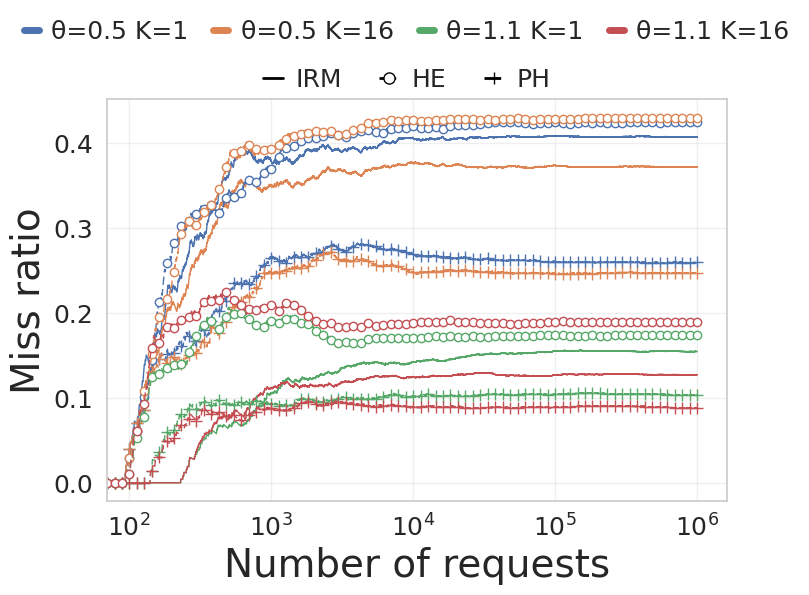

In [ ]:
C = 60
thetas = [0.5, 1.1]
Ks = [1, 16]
N_ITEMS = 120
TRACE_LEN = 1000000
X_MIN = 70
HE_DASH = (0, (6, 3))
MARKERS_PER_LINE = 80

palette = sns.color_palette("deep", len(thetas) * len(Ks))
color_map = {(theta, K): palette[i] for i, (theta, K) in enumerate((t, k) for t in thetas for k in Ks)}

def run_curve(trace, K):
    rc = tg.ran_clock(C=C, K=K)
    _, _, examined, misses = rc.run_age(trace)
    misses = np.cumsum(misses)
    xs = np.arange(1, len(trace) + 1)
    hr = misses / xs
    mask = xs >= X_MIN
    return xs[mask], hr[mask], np.asarray(examined)[mask]

fig, ax = plt.subplots(figsize=(8, 6))
combo_handles = []

for theta in thetas:
    trace_irm = gen_from_zipf(N_ITEMS, TRACE_LEN, theta)[1].astype(np.int32)
    for K in Ks:
        xs, hr, _ = run_curve(trace_irm, K)
        ax.plot(xs, hr, lw=1.0, linestyle="-", color=color_map[(theta, K)], label=None)
        combo_handles.append(Line2D([], [], color=color_map[(theta, K)], linestyle="-", lw=2.0))

for theta in thetas:
    trace_ph = gen_ph_2class(N_ITEMS, theta, TRACE_LEN, mu_ratio=10.0).astype(np.int32) - 1
    for K in Ks:
        xs, hr, _ = run_curve(trace_ph, K)
        mark_count = min(len(xs), MARKERS_PER_LINE)
        if len(xs) > 1:
            log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
            mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
        else:
            mark_indices = np.array([0])
        ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
                marker="+", markersize=8, markerfacecolor="white", markeredgewidth=1.0,
                markevery=mark_indices)

for theta in thetas:
    trace_he = gen_ph(N_ITEMS, theta, TRACE_LEN).astype(np.int32) - 1
    for K in Ks:
        xs, hr, _ = run_curve(trace_he, K)
        mark_count = min(len(xs), MARKERS_PER_LINE)
        if len(xs) > 1:
            log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
            mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
        else:
            mark_indices = np.array([0])
        ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
                marker="o", markersize=6, markerfacecolor="white", markeredgewidth=1.0,
                markevery=mark_indices)

ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Number of requests", fontsize=28)
ax.set_ylabel("Miss ratio", fontsize=28)
ax.set_xscale("log")
ax.set_xlim(left=X_MIN)
ax.grid(True, alpha=0.3)

labels = [f"θ={theta} K={K}" for theta in thetas for K in Ks]
style_handles = [
    Line2D([], [], color="black", linestyle="-", lw=2.0),
    Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="o", markersize=8, markerfacecolor="white", markeredgewidth=1.0),
    Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="+", markersize=8, markerfacecolor="white", markeredgewidth=1.0),
]

ncol_param = len(labels)
for h in combo_handles:
    h.set_linewidth(5.0)
fig.legend(handles=combo_handles, labels=labels,
           loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=ncol_param,
           fontsize=18, frameon=False, handlelength=0.6, handletextpad=0.5, columnspacing=1.0)

fig.legend(handles=style_handles, labels=["IRM", "HE", "PH"],
           loc="upper center", bbox_to_anchor=(0.5, 0.87), ncol=3,
           fontsize=18, frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1.5)

fig.subplots_adjust(top=0.78)

plt.savefig("ttf.pdf", bbox_inches="tight", format="pdf")
plt.show()


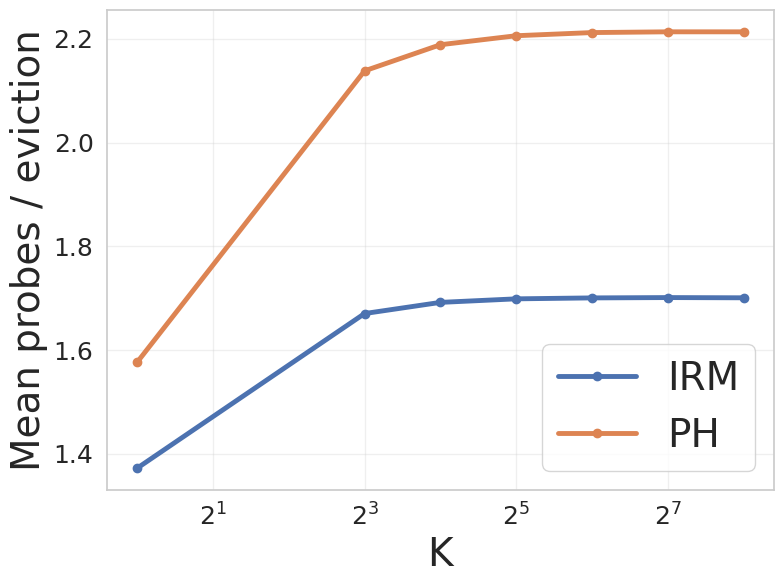

In [44]:

# ks = [1, 8, 16, 32, 64, 128, 256]
# mean_irm = np.empty(len(ks), dtype=float)
# mean_ph = np.empty(len(ks), dtype=float)

# for i, k in enumerate(ks):
#     rc = tg.ran_clock(C=24, K=k)
#     _, _, examined_irm_k, _ = rc.run_age(irm2)
#     _, _, examined_ph_k, _ = rc.run_age(ph2)

#     arr_irm = np.asarray(examined_irm_k, dtype=float)
#     arr_ph = np.asarray(examined_ph_k, dtype=float)
#     nz_irm = arr_irm > 0 
#     nz_ph = arr_ph > 0

#     mean_irm[i] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
#     mean_ph[i] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ks, mean_irm, marker='o', markersize=6, lw=3.5, label='IRM')
ax.plot(ks, mean_ph, marker='o', markersize=6, lw=3.5, label='PH')
ax.set_xscale("log", base=2)
ax.set_xlabel("K", fontsize=28)
ax.set_ylabel("Mean probes / eviction", fontsize=28)
ax.tick_params(axis="both", labelsize=18)
ax.legend(fontsize=28)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("mean_probes.pdf", bbox_inches="tight")
plt.show()



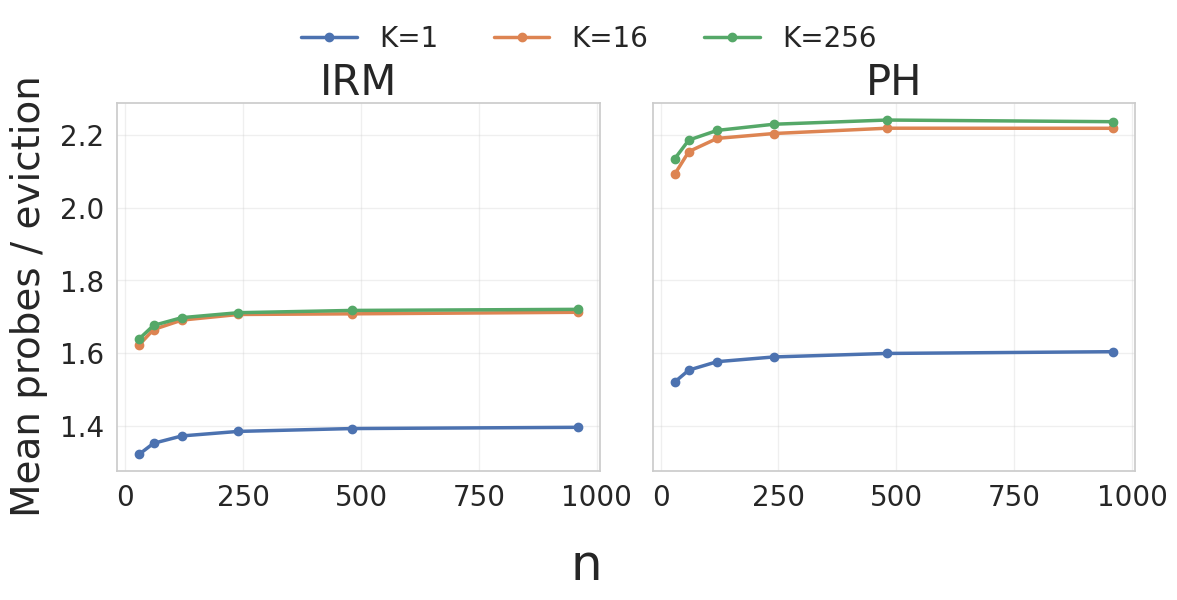

In [ ]:
k_values = [1, 16, 256]
ns = [30, 60, 120, 240, 480, 960]

means_irm = np.zeros((len(k_values), len(ns)), dtype=float)
means_ph = np.zeros_like(means_irm)

for ki, k in enumerate(k_values):
    for ci, n in enumerate(ns):
        trace_irm = gen_from_zipf(n, 1_000_000, 0.8)[1].astype(np.int32)
        trace_ph = gen_ph_2class(n, 0.8, 1_000_000, mu_ratio=10.0).astype(np.int32)
        c = max(1, n // 5)
        rc = tg.ran_clock(C=c, K=k)
        _, _, examined_irm_k, _ = rc.run_age(trace_irm)
        _, _, examined_ph_k, _ = rc.run_age(trace_ph)

        arr_irm = np.asarray(examined_irm_k, dtype=float)
        arr_ph = np.asarray(examined_ph_k, dtype=float)
        nz_irm = arr_irm > 0
        nz_ph = arr_ph > 0

        means_irm[ki, ci] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
        means_ph[ki, ci] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0     

palette = sns.color_palette("deep", len(k_values))
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

handles = []
for ax, means, title in [
    (axes[0], means_irm, r"IRM"),
    (axes[1], means_ph, r"PH"),
]:
    for k, color, vals in zip(k_values, palette, means):
        [line] = ax.plot(ns, vals, marker='o', markersize=6, lw=2.5, color=color, label=f"K={k}")
        handles.append(line)
    ax.set_title(title, fontsize=30)
    ax.tick_params(axis="both", labelsize=20)
    ax.grid(True, alpha=0.3)

fig.legend(
    handles=handles[:len(k_values)],
    labels=[f"K={k}" for k in k_values],
    loc="upper center",
    ncol=len(k_values),
    fontsize=20,
    frameon=False, 
)
fig.supxlabel("n", fontsize=36)
fig.supylabel("Mean probes / eviction", fontsize=28)
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.savefig("probe_vs_n.pdf", bbox_inches="tight")
plt.show()


In [30]:
# block io traces
w44 = np.loadtxt('/mnt/oldssd/opt/traces/w44_r.txt', dtype=np.int32)
w44[:, 0] += 7
w44 = tg.squash(tg.unroll(w44 // 8))

rc_w44_c, rc_w44_hr = sim_ran_clock(w44, cnt=1)
rc_w44_c16, rc_w44_hr16 = sim_ran_clock(w44, cnt=16)
cc_w44_c, cc_w44_hr = sim_clock(w44)
s_w44_c, sw44_hr = sim_sieve(w44)
f_w44_c, fw44_hr = sim_fifo(w44)

In [31]:
avgs_w44 = [('SIEVE', np.mean(np.array(sw44_hr))),
            ('CLOCK', np.mean(np.array(cc_w44_hr))),
            ('Ran-CLOCK K=16', np.mean(np.array(rc_w44_hr16))),
            ('Ran-CLOCK K=1', np.mean(np.array(rc_w44_hr))),
            ('FIFO', np.mean(np.array(fw44_hr)))]
avgs_w44.sort(key=lambda x: x[1], reverse=True)
print("w44 Average Hit Rates:")
for name, avg in avgs_w44:
    print(f"{name}: {avg}") 

w44 Average Hit Rates:
SIEVE: 0.4019689661564687
Ran-CLOCK K=16: 0.398648865842543
Ran-CLOCK K=1: 0.38961544826521904
CLOCK: 0.29175590496281195
FIFO: 0.24001764958756922


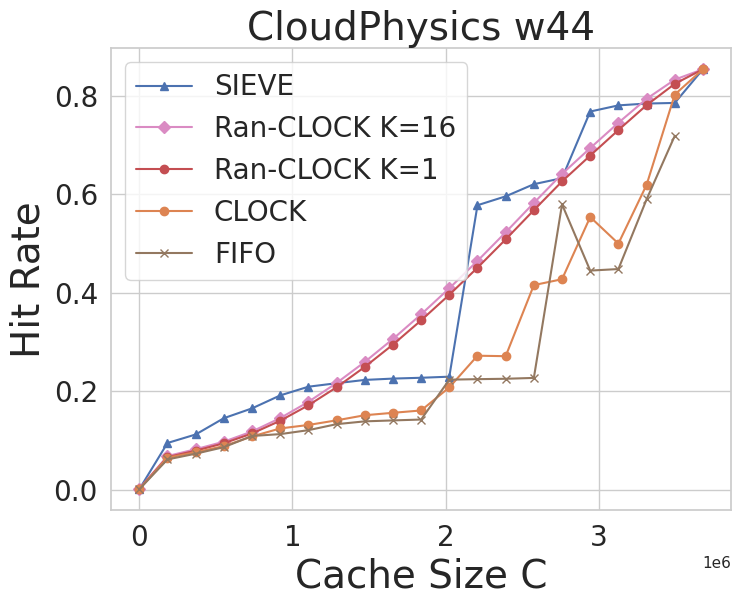

In [34]:
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(s_w44_c, sw44_hr, color=palette[0], marker='^', label='SIEVE')
plt.plot(rc_w44_c16, rc_w44_hr16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(rc_w44_c, rc_w44_hr, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cc_w44_c, cc_w44_hr, color=palette[1], marker='o', label='CLOCK')
plt.plot(f_w44_c, fw44_hr, color=palette[5], marker='x', label='FIFO')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=20)
plt.title('CloudPhysics w44', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_w44.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [4]:
# Meta CDN
import duckdb
con = duckdb.connect(':memory:')

result = con.execute("""
select *, regexp_extract(filename, '.*/([^/]+)\\.csv\\.zst', 1) as server
from read_csv(
    '/mnt/sda/metacdn/reag0c01_20230315_20230322_0.2000.csv.zst', 
    delim=',',
    header=true,
    filename=true,
    strict_mode=false
    )
limit 100
""")
result.df().tail()

,timestamp,cacheKey,OpType,objectSize,responseSize,responseHeaderSize,rangeStart,rangeEnd,TTL,SamplingRate,cache_hit,item_value,RequestHandler,cdn_content_type_id,vip_type,filename,server
95,1678863586794,0067813359500000000000000000000000000000000000...,1,155124,155664,450,0,8388607,1209600,0.0001,1,1,1000,2,2000,/mnt/sda/metacdn/reag0c01_20230315_20230322_0....,reag0c01_20230315_20230322_0.2000
96,1678863586807,0067813359500000000000000000000000000000000000...,1,155124,216,207,8388608,16777215,-1,0.0001,1,1,1000,2,2000,/mnt/sda/metacdn/reag0c01_20230315_20230322_0....,reag0c01_20230315_20230322_0.2000
97,1678863587000,0067813354200000000000000000000000000000000000,1,5776,6439,663,-1,-1,1209600,0.0001,1,1,1003,3,2000,/mnt/sda/metacdn/reag0c01_20230315_20230322_0....,reag0c01_20230315_20230322_0.2000
98,1678863587033,0067813360100000000000000000000000000000000000...,1,896,1637,741,-1,-1,1209600,0.0001,1,1,1001,1,2000,/mnt/sda/metacdn/reag0c01_20230315_20230322_0....,reag0c01_20230315_20230322_0.2000
99,1678863587076,0067813360200000000000000000000000000000000000...,1,4824,5593,769,-1,-1,1209600,0.0001,0,1,1001,10,2000,/mnt/sda/metacdn/reag0c01_20230315_20230322_0....,reag0c01_20230315_20230322_0.2000


In [36]:
trace_path = '/mnt/sda/metacdn/reag0c01_20230315_20230322_0.2000.csv.zst'
out_path = '/mnt/sda/metacdn/keys_sizes.parquet'

key_size_query = f"""
select cacheKey, objectSize
from read_csv(
    '{trace_path}',
    delim=',',
    header=true,
    auto_detect=true,
    filename=false
)
"""

con.execute(f"COPY ({key_size_query}) TO '{out_path}' (FORMAT PARQUET);")


In [30]:
parquet_path = '/mnt/sda/metacdn/keys_sizes.parquet'
bytes_per_unit = 65536
max_rows = 10_000_000

q = f"select cacheKey, objectSize from '{parquet_path}' limit {max_rows}"
cur = con.execute(q)

keys_parts, sizes_parts = [], []
while True:
    df = cur.fetch_df_chunk(1_000_000)
    if df.empty:
        break
    df = df[df.objectSize > 0]
    keys_parts.append(df['cacheKey'].reset_index(drop=True))
    sizes_parts.append(df['objectSize'].to_numpy(np.int64))

series = pd.concat(keys_parts, ignore_index=True)
key_ids, _ = pd.factorize(series, sort=False)
cdn_trc = key_ids.astype(np.int32)  # request-level trace

sizes = np.concatenate(sizes_parts)
lengths = np.maximum(1, (sizes + bytes_per_unit - 1) // bytes_per_unit).astype(np.int32)

len_addr = np.empty((len(lengths), 2), dtype=np.int32)
len_addr[:, 0] = lengths
len_addr[:, 1] = cdn_trc
cdn_trc_bytes = tg.squash(tg.unroll(len_addr)) 

c_bytes = [2**e for e in range(24, 34)]                 # 16MB .. 32GB
c_blocks = [cb // bytes_per_unit for cb in c_bytes]
xs_mb = [cb / 1024**2 for cb in c_bytes]

In [ ]:
arr = cdn_trc_bytes.astype(np.int32)  
np.save("/mnt/sda/metacdn/cdn_trc_bytes.npy", arr)

arr2 = cdn_trc.astype(np.int32)  
np.save("/mnt/sda/metacdn/cdn_trc_keys.npy", arr2)


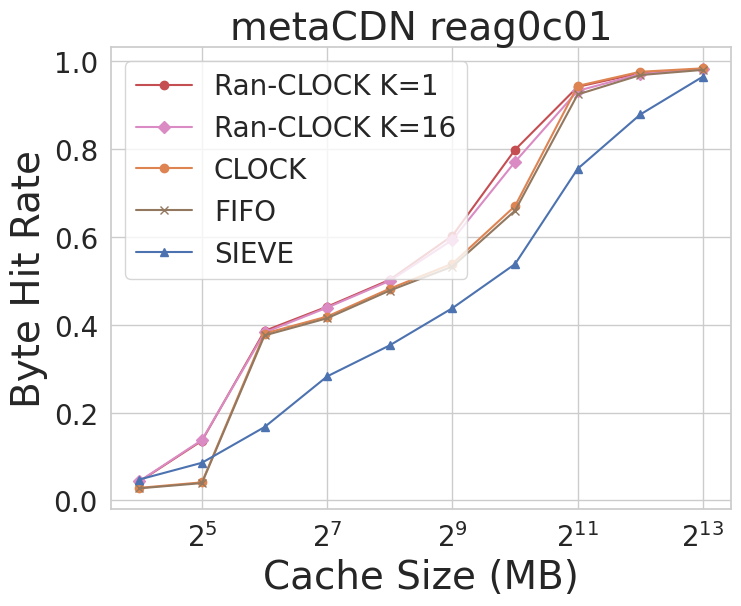

In [43]:

# hrs_rc1, hrs_rc16, hrs_clk, hrs_siv, hrs_fifo = [], [], [], [], []
# for cb, C in zip(c_bytes, c_blocks):
#     hrs_rc1.append(tg.sim_ran_clock(C, cdn_trc_bytes, raw=True, K=1))
#     hrs_rc16.append(tg.sim_ran_clock(C, cdn_trc_bytes, raw=True, K=16))
#     hrs_clk.append(tg.sim_clock(C, cdn_trc_bytes, raw=True))
#     hrs_siv.append(tg.sim_sieve(C, cdn_trc_bytes, raw=True))
#     hrs_fifo.append(tg.sim_fifo(C, cdn_trc_bytes, raw=True))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)

plt.plot(xs_mb, hrs_rc1,  color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(xs_mb, hrs_rc16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(xs_mb, hrs_clk,  color=palette[1], marker='o', label='CLOCK')
plt.plot(xs_mb, hrs_fifo, color=palette[5], marker='x', label='FIFO')
plt.plot(xs_mb, hrs_siv,  color=palette[0], marker='^', label='SIEVE')
plt.xscale('log', base=2)
plt.xlabel('Cache Size (MB)', fontsize=28)
plt.ylabel('Byte Hit Rate', fontsize=28)
plt.legend(fontsize=20)
plt.title('metaCDN reag0c01', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_cdn_bytes.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [26]:
np.savetxt("data/cdn_mrcs.txt", np.column_stack((xs_mb, hrs_siv, hrs_clk, hrs_rc1, hrs_rc16, hrs_fifo)), fmt="%.6f",
           header="CacheSizeMB SIEVE CLOCK RanCLOCK_K1 RanCLOCK_K16 FIFO")

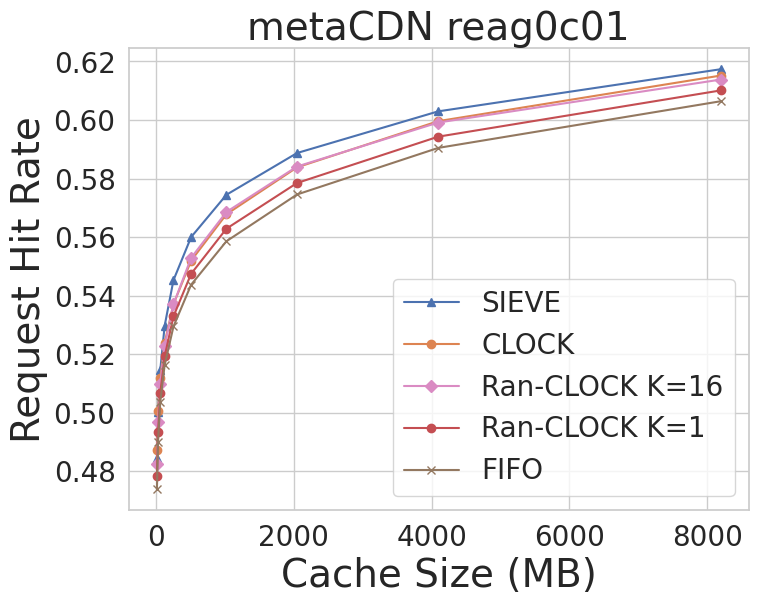

In [45]:
# hrs_rq_rc1, hrs_rq_rc16, hrs_rq_clk, hrs_rq_siv, hrs_rq_fifo = [], [], [], [], []
# for C in c_blocks:
#     hrs_rq_rc1.append(tg.sim_ran_clock(C, cdn_trc, raw=True, K=1))
#     hrs_rq_rc16.append(tg.sim_ran_clock(C, cdn_trc, raw=True, K=16))
#     hrs_rq_clk.append(tg.sim_clock(C, cdn_trc, raw=True))
#     hrs_rq_siv.append(tg.sim_sieve(C, cdn_trc, raw=True))
#     hrs_rq_fifo.append(tg.sim_fifo(C, cdn_trc, raw=True))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(xs_mb, hrs_rq_siv,  color=palette[0], marker='^', label='SIEVE')
plt.plot(xs_mb, hrs_rq_clk,  color=palette[1], marker='o', label='CLOCK')
plt.plot(xs_mb, hrs_rq_rc16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(xs_mb, hrs_rq_rc1,  color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(xs_mb, hrs_rq_fifo, color=palette[5], marker='x', label='FIFO')
# plt.xscale('log', base=2)
plt.xlabel('Cache Size (MB)', fontsize=28)
plt.ylabel('Request Hit Rate', fontsize=28)
plt.legend(fontsize=20)
plt.title('metaCDN reag0c01', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_cdn_requests.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [33]:
np.savetxt("data/cdn_mrcs_requests.txt", np.column_stack((xs_mb, hrs_rq_siv, hrs_rq_clk, hrs_rq_rc1, hrs_rq_rc16, hrs_rq_fifo)), fmt="%.6f",
           header="CacheSizeMB SIEVE CLOCK RanCLOCK_K1 RanCLOCK_K16 FIFO")

In [34]:
avgs_cdn = [('SIEVE', np.mean(np.array(hrs_rq_siv))),
            ('CLOCK', np.mean(np.array(hrs_rq_clk))),
            ('Ran-CLOCK K=16', np.mean(np.array(hrs_rq_rc16 ))),
            ('Ran-CLOCK K=1', np.mean(np.array(hrs_rq_rc1 ))),
            ('FIFO', np.mean(np.array(hrs_rq_fifo)))]
avgs_cdn.sort(key=lambda x: x[1], reverse=True)
print("metaCDN Average Hit Rates:")
for name, avg in avgs_cdn:
    print(f"{name}: {avg}")

metaCDN Average Hit Rates:
SIEVE: 0.5517551321421297
CLOCK: 0.5478996960229227
Ran-CLOCK K=16: 0.5467573301864987
Ran-CLOCK K=1: 0.5424035678043537
FIFO: 0.5386872725801337


In [ ]:
print(bytes_per_unit)
print(len(cdn_trc_bytes), "==", lengths.sum()) 
print(c_blocks, [cb // bytes_per_unit for cb in c_bytes])  

for arr in [hrs_rc1, hrs_rc16, hrs_clk, hrs_siv, hrs_fifo]:
    print(all(x2 >= x1 for x1, x2 in zip(arr, arr[1:])))


65536
1208429253 == 1208429253
[256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072] [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
True
True
True
True
True
